In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys

from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter

plt.style.use("~/evanstyle.mplstyle")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools

In [16]:
#toproot = "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/"
toproot = "../../data/"
topdirs = {5:toproot+"Run5/", 6:toproot+"Run6/", 7:toproot+"Run7/", 8:toproot+"Run8/", 9:toproot+"Run9/", 10:toproot+"Run10/"}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml", 10:"../configs/run10_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"MgF2 (50nm)", 8:"Pt (50nm)", 9:"MgF2 (20nm)", 10:"SS304"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    if(n == 6 or n == 5):continue
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])



on directory:  ../../data/Run7/ds05
on directory:  ../../data/Run7/ds02
on directory:  ../../data/Run7/ds03
on directory:  ../../data/Run7/ds04
on directory:  ../../data/Run7/ds10
on directory:  ../../data/Run7/ds11
on directory:  ../../data/Run7/ds01
on directory:  ../../data/Run7/ds06
on directory:  ../../data/Run7/ds08
on directory:  ../../data/Run7/ds09
on directory:  ../../data/Run7/ds07
on directory:  ../../data/Run8/ds05
on directory:  ../../data/Run8/ds02
on directory:  ../../data/Run8/ds03
on directory:  ../../data/Run8/ds04


/Users/ejangelico/Documents/Stanford/GasBreakdownChamber/code/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:136: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


on directory:  ../../data/Run8/ds10
on directory:  ../../data/Run8/ds11
on directory:  ../../data/Run8/ds01
on directory:  ../../data/Run8/ds06
on directory:  ../../data/Run8/ds08
on directory:  ../../data/Run8/ds09
on directory:  ../../data/Run8/ds07
on directory:  ../../data/Run8/ds00
on directory:  ../../data/Run8/ds12
on directory:  ../../data/Run9/ds05
on directory:  ../../data/Run9/ds02
on directory:  ../../data/Run9/ds03
on directory:  ../../data/Run9/ds04
on directory:  ../../data/Run9/ds10
on directory:  ../../data/Run9/ds11
on directory:  ../../data/Run9/ds01
on directory:  ../../data/Run9/ds06
on directory:  ../../data/Run9/ds08
on directory:  ../../data/Run9/ds09
on directory:  ../../data/Run9/ds07
on directory:  ../../data/Run9/ds13
on directory:  ../../data/Run9/ds14
on directory:  ../../data/Run9/ds12
on directory:  ../../data/Run10/ds05
on directory:  ../../data/Run10/ds02
on directory:  ../../data/Run10/ds03
on directory:  ../../data/Run10/ds04
on directory:  ../../dat

In [17]:
#load data into mem if you want
for n, ana in anas.items():
    if(n == 6 or n == 5): continue
    ana.load_dataframe()

# Developing better HV interpolation
### The present dataset.py code doesn't do a great job of analyzing the ramp.txt and g_events.txt files to the degree that we want. The biggest drawback is that only voltage datapoints are logged when the glassman control loop is running. So interpreting what happens in the gaps can be wrong.

In [25]:
ana = anas[9]
ana.load_hv_textfiles()
ana.correct_hv_data()

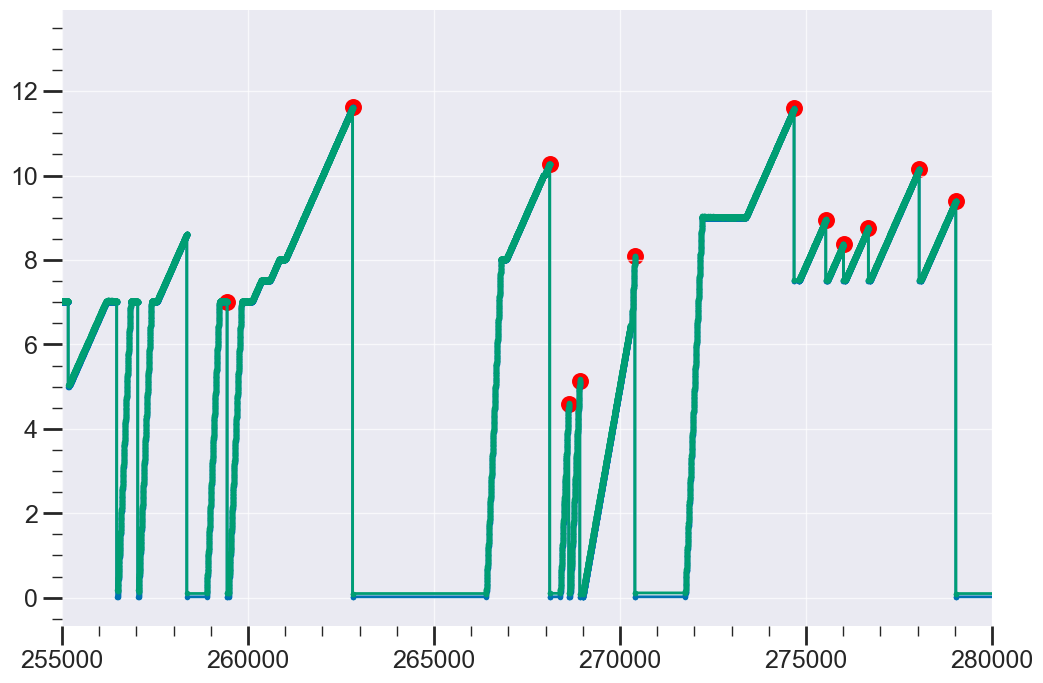

In [66]:
rd = ana.ramp_data
rd = rd.sort_values("t")
ge = ana.g_event_data

ge_ts = ge["t"] - np.min(rd["t"])
rd_ts = rd["t"] - np.min(rd["t"])


fig, ax = plt.subplots()
ax.plot(rd_ts, rd["v_app"], 'o-')
ax.plot(rd_ts, rd["v_mon"], 'o-')
ax.scatter(ge_ts, ge["v_app"], color='red', s=500)
ax.set_xlim([255000, 280000])
#ax.set_ylim([0, 0.15])
plt.show()

In [68]:
ana.create_time_duration_map()

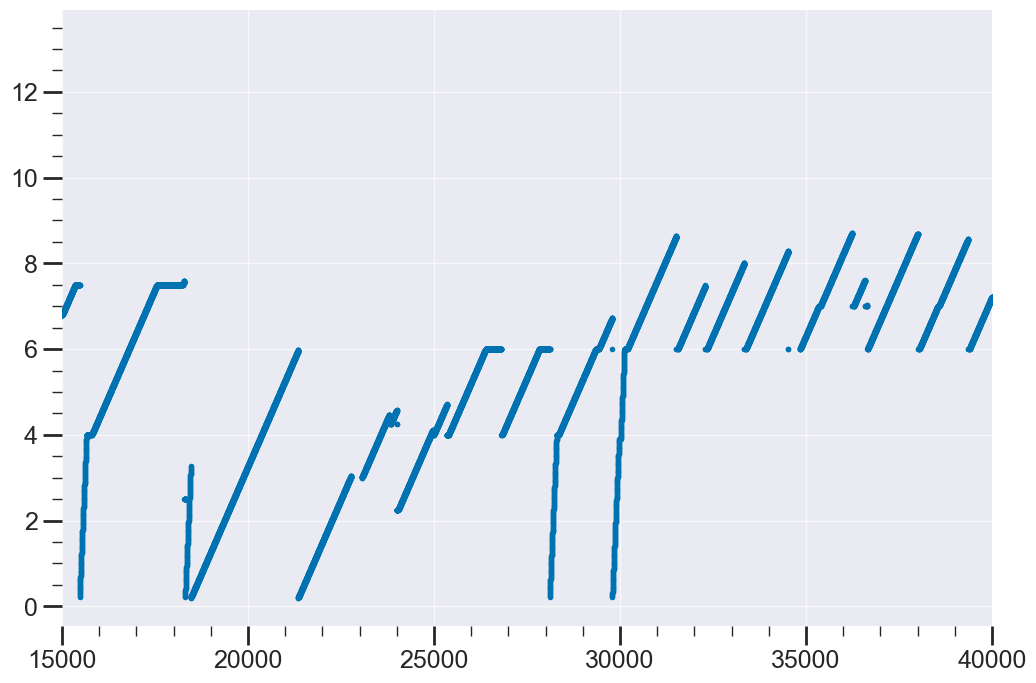

In [71]:
ts = ana.time_duration_map["t"]
durs = ana.time_duration_map["dur"]
vs = ana.time_duration_map["v"]
fig, ax = plt.subplots()
ax.plot(durs, vs, 'o')
ax.set_xlim([15000, 40000])
plt.show()

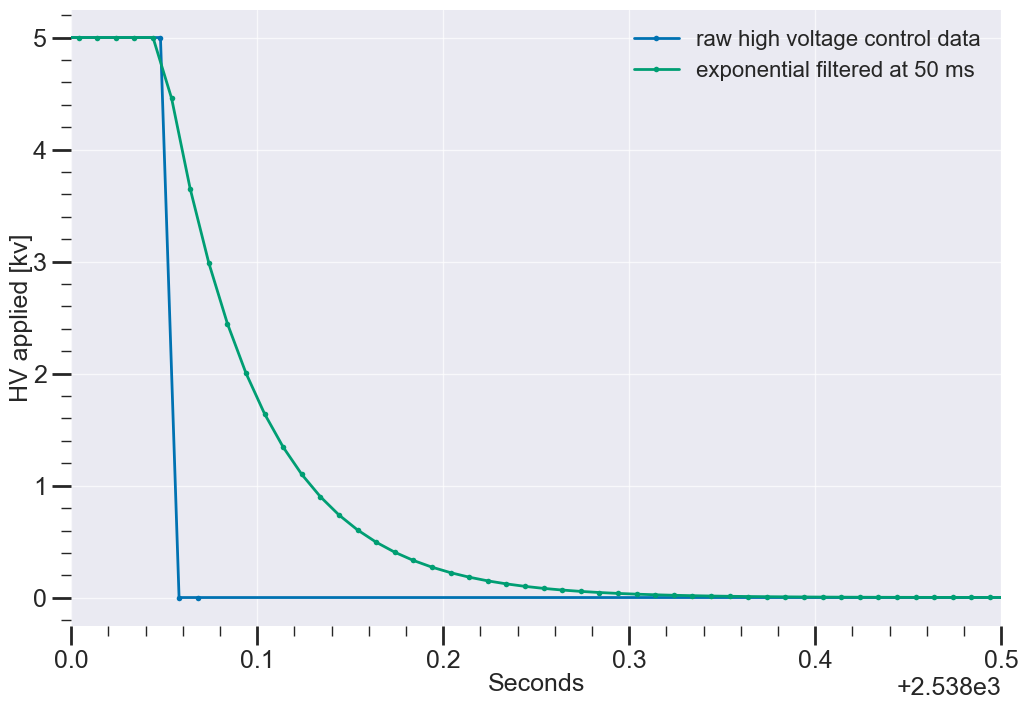

In [17]:
from scipy.interpolate import interp1d
rd = ana.ramp_data
rd = rd.sort_values("t")
ge = ana.g_event_data
ge = ge.sort_values("t")

ge_ts = ge["t"] - np.min(rd["t"])
rd_ts = rd["t"] - np.min(rd["t"])

bd = [2400, 2450]
x_bd = np.array(rd_ts[bd[0]:bd[1]])
y_bd = np.array(rd["v_app"])[bd[0]:bd[1]]

fine_x = np.arange(x_bd[0], x_bd[-1], 0.01)
s = interp1d(x_bd, y_bd)
fine_y = s(fine_x)

filty, filtx = ana.exponential_filter(fine_x, fine_y, 0.05)

fig, ax = plt.subplots()
ax.plot(x_bd, y_bd, 'o-', label="raw high voltage control data")
ax.plot(filtx, filty, 'o-', label="exponential filtered at 50 ms")

ax.legend()
ax.set_xlim([2538, 2538.5])
ax.set_xlabel("Seconds")
ax.set_ylabel("HV applied [kv]")
plt.show()

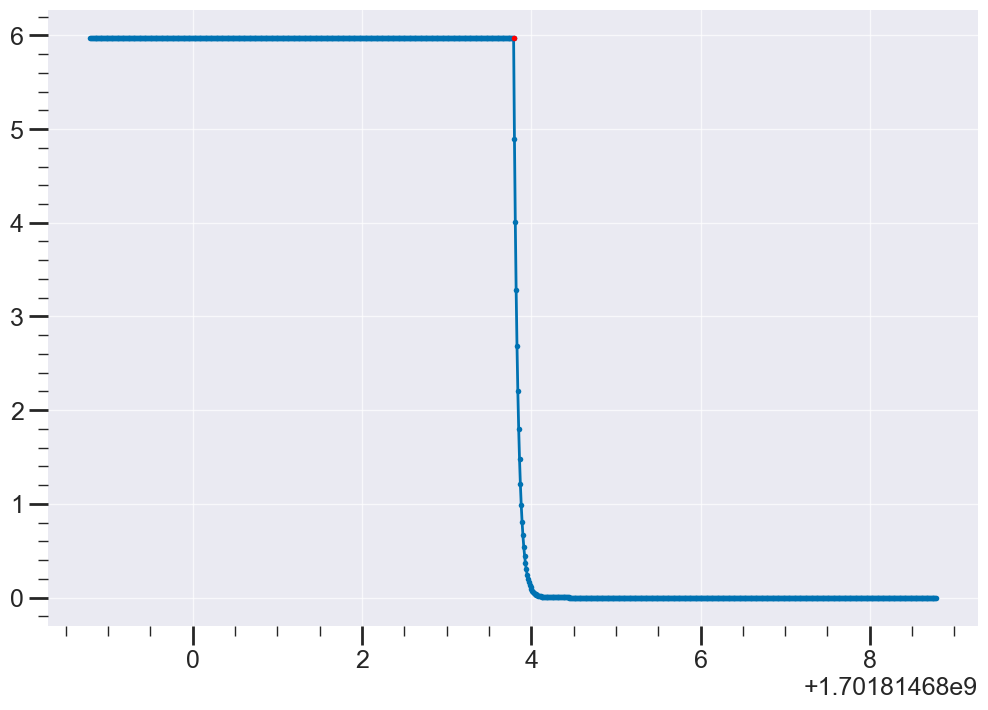

In [26]:
gedf = ana.g_event_data
ge_ev = gedf.sample()
bd = [ge_ev["t"].iloc[0] - 5, ge_ev["t"].iloc[0] + 5]
ts = np.arange(bd[0], bd[1], 0.01)
hv = [ana.get_hv_at_time(t) for t in ts]
fig, ax = plt.subplots()
ax.plot(ts, hv, 'o-')
ax.plot(ge_ev["t"], ge_ev["v_app"], 'o', color='red')
plt.show()



Processing ../../data/Run8/ds05
Processing ../../data/Run8/ds02
Processing ../../data/Run8/ds03
Processing ../../data/Run8/ds04
Processing ../../data/Run8/ds10
Processing ../../data/Run8/ds11
Processing ../../data/Run8/ds01
Processing ../../data/Run8/ds06
Processing ../../data/Run8/ds08
Processing ../../data/Run8/ds09


/Users/ejangelico/Documents/Stanford/GasBreakdownChamber/code/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:137: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  #there is a silly thing with genfromtxt where if its a 1 line file, it makes a 1D array instead of the usual


Processing ../../data/Run8/ds07
Processing ../../data/Run8/ds00
Processing ../../data/Run8/ds12


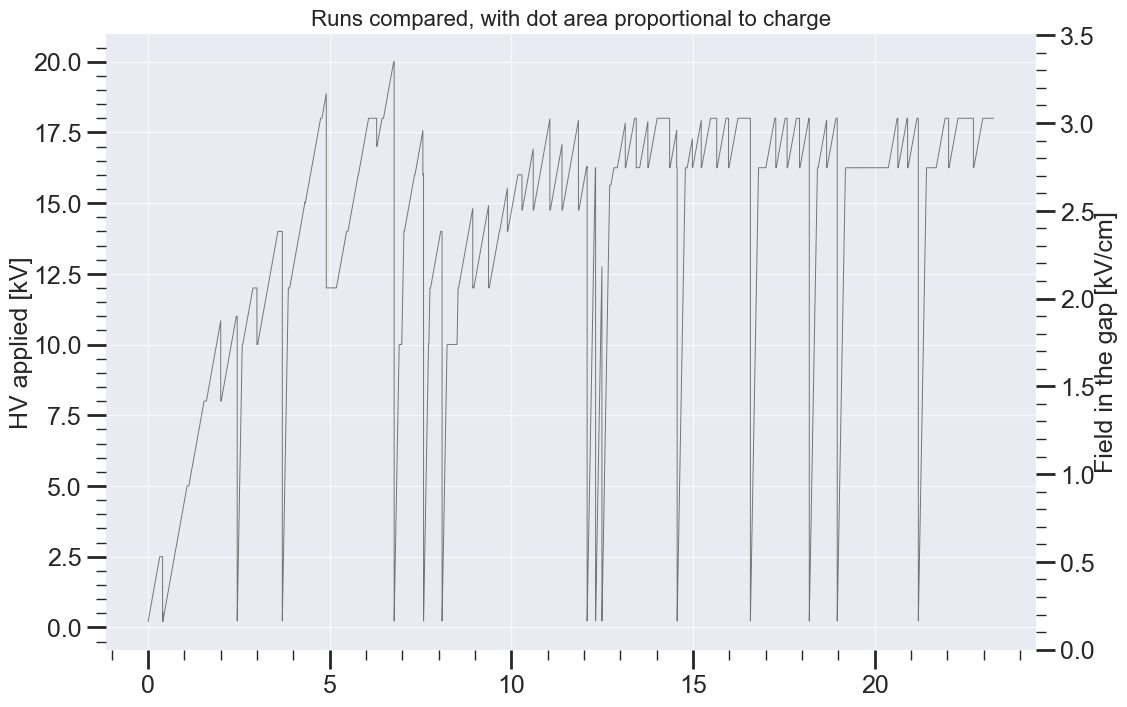

In [42]:

fig, ax = plt.subplots()
#ax.set_ylim([-1, 19]) #fixed axis for all
#ax.set_xlim([-1, 42])
ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])


for i, run in enumerate([8]):
    ana = anas[run]
    ana.load_hv_textfiles()
    ana.correct_hv_data()
    ana.create_time_duration_map()
    d = ana.df
    d = d[~d["ch3 charge"].isna()]
    tdmap = ana.time_duration_map
    #ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color='k', linewidth=0.7, alpha=0.5)

    #negative polar events
    mask = (d["ch3 n negpeaks"] > 0) & (d["ch3 n pospeaks"] == 0) & (np.abs(d["ch3 charge"]) > 1)
    #if(run == 10):
        #mask = (np.abs(d["ch3 charge"]) > 2) #positive peaks allowed, because it was the only thing observed. 
    d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])
    d_E = np.array(d[mask]["ch3 field"])

    #recast time
    hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
    #ax.scatter(hv_event_durs, d_hv, marker='o', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])
    #ax.plot(hv_event_durs, d_hv, 'k-', alpha=0.3)
    #negative polar events
    mask = (d["ch3 n negpeaks"] == 0) & (d["ch3 n pospeaks"] > 0) 
    d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])
    d_E = np.array(d[mask]["ch3 field"])

    

    #duration curve
    ax.plot(np.array(ana.time_duration_map["dur"])/3600, ana.time_duration_map["v"], 'k-', linewidth=0.7, alpha=0.5)
    #ax.plot(np.array(ana.time_duration_map["t"]), ana.time_duration_map["v"], 'ko-', linewidth=0.7, alpha=0.5)
    

ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
#ax.set_xlim([0, 2])
ax2.grid(False)
#ax.set_xlabel("Duration with voltage applied [hours]")
ax.set_title("Runs compared, with dot area proportional to charge")
plt.show()


In [31]:
temp = ana.ramp_data[ana.ramp_data["v_app"] > 18]
print(np.array(temp["t"])[0])


1690506329.479
